In [1]:
import numpy as np
import cv2
import glob
import time
import pickle
from collections import deque
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
# from sklearn.cross_validation import train_test_split  # for scikit-learn version <= 0.17
from sklearn.model_selection import train_test_split  # if you are using scikit-learn >= 0.18
from scipy.ndimage.measurements import label

from includes.car_classification import *
from includes.car_detection import *

## Classifier

Car images: 8792
Non-car images: 8968


/home/ele_16/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


5292
5292
5292
5292
5292
5292


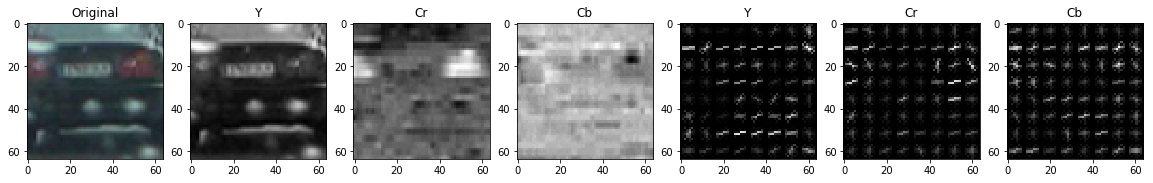

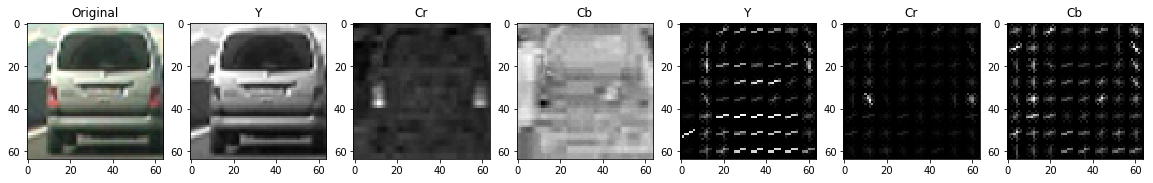

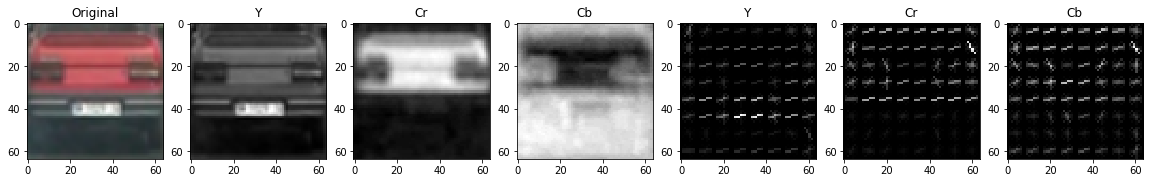

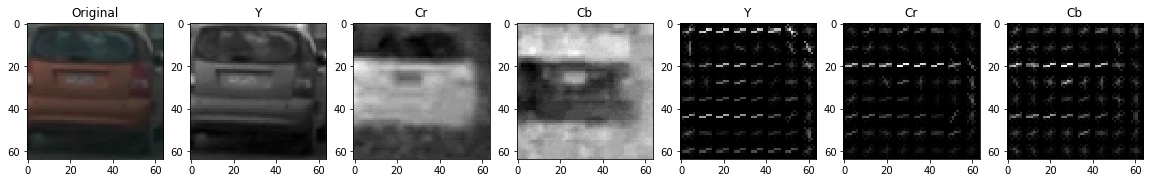

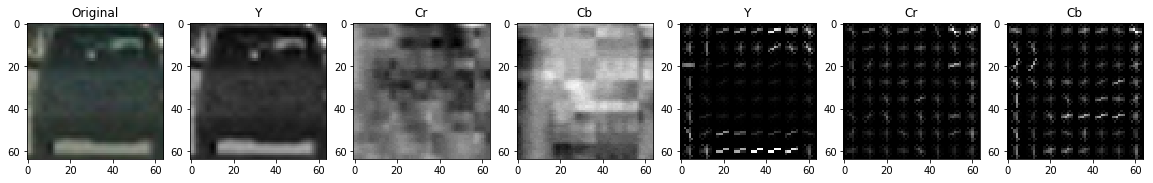

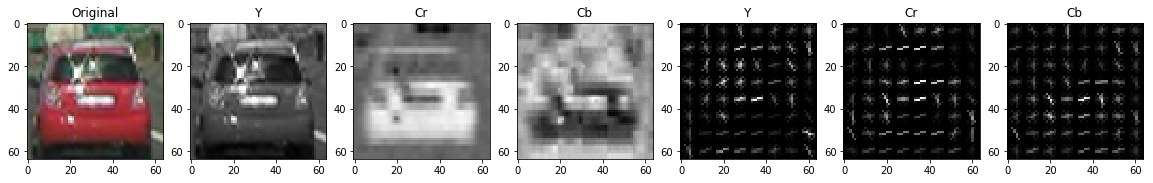

In [2]:
cars = glob.glob('classification_datasets/vehicles/**/*.png', recursive=True)
notcars = glob.glob('classification_datasets/non-vehicles/**/*.png', recursive=True)
print('Car images: {}'.format(len(cars)))
print('Non-car images: {}'.format(len(notcars)))

# sample_size = 100
sample_size = None
if sample_size is not None:
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]
    
## Feature parameters
parameters = {'colorspace': 'YCrCb',            # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
              'hog_channel': 'ALL',             # Can be 0, 1, 2, or "ALL"
              'hog_orient': 9,                  # HOG possible orientations    9 11
              'hog_pix_per_cell': 8,            # HOG number of px per cell    8 16
              'hog_cell_per_block': 2,          # HOG number of cells per block
              'spatial_size': (32, 32),         # Spatial binning dimensions
              'histogram_bins': 32}             # Number of histogram bins

if 1:
    # Extract features for writeup
    extract_features_from_image_list(cars[100:106], show_intermediate=True)

if 0:
    train_classifier(cars, notcars, parameters, "model_linearsvc_9_8")

## Detect cars in camera image

In [ ]:
# Load classifier and scaler
# model = pickle.load(open("models/model_linearsvc_11_16.p", "rb"))
model = pickle.load(open("models/model_linearsvc_9_8.p", "rb"))
svc = model["model"]
scaler = model["scaler"]
colorspace = model["colorspace"]
hog_channel = model["hog_channel"]
hog_orient = model["hog_orient"]
hog_pix_per_cell = model["hog_pix_per_cell"]
hog_cell_per_block = model["hog_cell_per_block"]
spatial_size = model["spatial_size"]
histogram_bins = model["histogram_bins"]

# Read camera image
test_files = glob.glob('test_images/*.jpg')
# test_files = ['test_images/test3.jpg']

# Process files
for file in test_files:
    
    # Load image
    image = mpimg.imread(file)
    
    # Initialize detector
    detector = VehicleDetector(classifier=svc,
                               scaler=scaler,
                               colorspace=colorspace,
                               hog_channel=hog_channel,
                               hog_orient=hog_orient,
                               hog_pix_per_cell=hog_pix_per_cell,
                               hog_cell_per_block=hog_cell_per_block,
                               spatial_size=spatial_size,
                               histogram_bins=histogram_bins,
                               show_intermediate_results=True)
    
    # Run search
    t0 = time.time()
    labelled_img = detector.search_in_image(image)
    t_detection = time.time() - t0
    print("Time for detection: {:6.4f}s".format(t_detection))
    
    # Show result
    if 0:
        f, ax = plt.subplots(1,1, figsize=(20,10))
        ax.imshow(labelled_img)

## Detect cars in video

In [ ]:
from moviepy.editor import VideoFileClip

# filename = "test_video.mp4"
filename = "project_video.mp4"
clip = VideoFileClip(filename)
white_output = filename[:-4] + '_output.mp4'

# Initialize detector
detector = VehicleDetector(classifier=svc,
                           scaler=scaler,
                           colorspace=colorspace,
                           hog_channel=hog_channel,
                           hog_orient=hog_orient,
                           hog_pix_per_cell=hog_pix_per_cell,
                           hog_cell_per_block=hog_cell_per_block,
                           spatial_size=spatial_size,
                           histogram_bins=histogram_bins,
                           show_intermediate_results=False)

white_clip = clip.fl_image(detector.search_in_image)
#white_clip = clip.fl_image(detector.search_in_image).subclip(4, 10)
#white_clip = clip.fl_image(detector.search_in_image).subclip(19, 27)
#white_clip = clip.fl_image(detector.search_in_image).subclip(45, 47)

%time white_clip.write_videofile(white_output, audio=False)